# Topological Uncertainty

Author: Théo Lacombe

**Goal:** This notebook presents ways to use Topological Uncertainty (TU) on (sequential, tensorflow) neural networks on toy examples. It also shows how to reproduce the OOD-detection experiment described in the [reference paper](https://hal.archives-ouvertes.fr/hal-03213188/document) with graph datasets.

Dependecies: the current code was tested on Ubuntu 20, with the following libraries:
- `Python 3.8` *
- `Tensorflow 2.4` *  (backend for neural networks architectures)
- `gudhi 3.3.0` *  (used to store activation graphs and compute MST/diagrams on top of them)
- `numpy 1.20.2` *
- `matplotlib 3.3.2`
- `pandas 1.2.4`  (used to store features computed from MUTAG and COX2)

Note: * mark librairies that are intrinsiquely related to computing topological uncertainty (contrary to, for instance, `matplotlib` or `pandas` that are used for visualization).

You need to install them (preferrably in a dedicated conda env) before running the code.

### Imports libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import from external libraries.

In [2]:
import numpy as np
import matplotlib.pylab as plt

Import our implementation to compute topological uncertainty

In [3]:
import utils.utils_graphs as ug
import utils.utils_notebook as unb
import utils.utils_tda as utda

2022-02-16 12:49:03.350168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 12:49:03.350182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Graphs datasets (`MUTAG`, `COX2`, and their `Fake-` counterparts) are stored as `.mat` files, located in the `./%s/mat/` folder, where `%s` is the dataset name. Spectral features are computed on top of graphs and are provided in the `./%s/%s.csv` files (see at the end of the notebook if you want to rebuild Fake datasets and graphs features).

# 1.Topological uncertainty from graphs directly

## 1.1 Preliminary remarks

Extracting topological information from graphs using our technique can be done in a fairly general setting, not restricted to activation graphs of neural networks. 

Below, we show how you can extract persistence diagrams from graphs using a method `diag_from_numpy_array` in the `utils.utils_tda` module. Diagrams can then be compared using the method `wasserstein_distance_1D` (in the same file).

In [4]:
# Preliminary example : diagram from a random adjacency matrix. 
n = 275  # number of point in the graph
A = unb.sample_adjancency_matrix(n=275)
print("shape of our adjancency matrix:", A.shape)

shape of our adjancency matrix: (275, 275)


In [5]:
# We compute its diagram using Gudhi
dgm = utda.diag_from_numpy_array(A)
print("shape of the resulting diagram:", dgm.shape)

shape of the resulting diagram: (274,)


Now we build another random adjacency matrix, its diagram, and compute the distance between the two diagrams.

In [6]:
A2 = unb.sample_adjancency_matrix(n=275)

In [7]:
dgm2 = utda.diag_from_numpy_array(A2)

In [8]:
print("distance between the two diagrams:", utda.wasserstein_distance_1D(dgm, dgm2))

distance between the two diagrams: 0.0001471371821500384


## 1.2 Illustration on a set of graphs

Topological uncertainty consists of comparing a new observation (in our case a new graph) with respect to a sample of reference graphs.
The average topology of our sample of training graphs will be summarized through the _Fréchet mean_ (a.k.a barycenter) of the corresponding diagrams, which can be computed using `utils.utils_tda.wasserstein_barycenter_1D`. 

For illustrative purpose, the graphs we sample come from point clouds of different shape (with fixed cardinality): our "reference samples" come from points sampled on a clean circle. Our new observations consist of circles with addition of some noise, where the noise amplitude progressively increases.

In [9]:
# Build set of graphs/point clouds.
nb_reference_graph = 500
nb_points = 100
radius = 1
circles = np.array([unb.sample_circle(n=nb_points, r=radius, noise=0) for _ in range(nb_reference_graph)])

In [10]:
# Now turn these point clouds into diagrams
diags = [utda.diag_from_point_cloud(C) for C in circles]

In [11]:
# And finally compute the barycenter of these reference diagrams:
barycenter = utda.wasserstein_barycenter_1D(diags)

In [12]:
# Now we sample noisy circles, for increasing noise level ; and compute their respective diagrams.
# Note: these noisy circles must have the same number of points as the clean ones 
#       (graph combinatorics should remain unchanged).

sigmas = np.linspace(0.1, 2*radius, 5)
nb_noisy_cirlce_per_noise_level = 500

# Sample the noisy circles for various noise level sigma
noisy_circles = np.array([[unb.sample_circle(n=nb_points, r=radius, noise=sigma) 
                  for _ in range(nb_noisy_cirlce_per_noise_level)] 
                 for sigma in sigmas])

# Compute their diagrams
diags_of_noisy_circles = [[utda.diag_from_point_cloud(C) for C in circles_noise_sigma] 
                          for circles_noise_sigma in noisy_circles]

Let us visualize all of these.

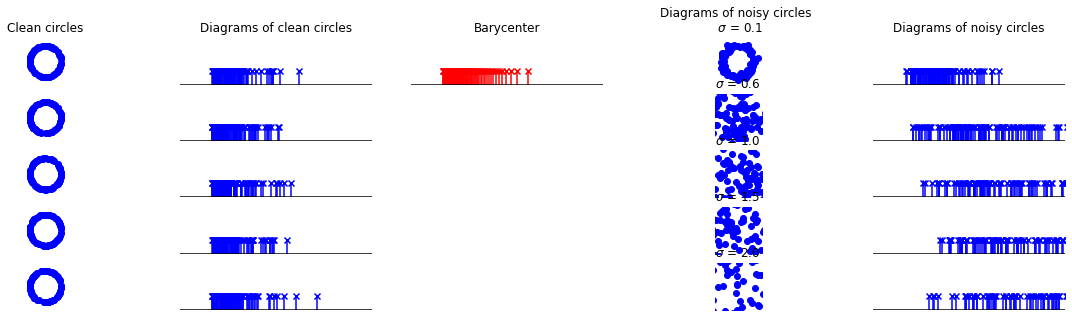

In [13]:
unb.visu_notebook(circles, diags, barycenter, noisy_circles, diags_of_noisy_circles, sigmas)

Intuitively, the noisier the circle, the more different the distance between its diagram and the average diagram we obtained from our clean circles. 
The distance between the diagram of a new observation and a Fréchet mean is called the _Topological Uncertainty_ (TU) of this new observation. A large TU - with respect to distance from reference diagrams to the Fréchet mean - is likely to account for anomalies/shift in the distribution/etc.

First, we compute the distance between our reference diagrams (those obtained from clean circles) and their Fréchet mean. This can be understood as a notion of variance for the training set.

In [14]:
distrib_TU_clean = np.array([utda.wasserstein_distance_1D(dgm, barycenter) for dgm in diags])

Now we do the same for the diagrams coming from noisy circles (for each noise level $\sigma$).

In [15]:
distrib_TU_noisy = np.array([[utda.wasserstein_distance_1D(dgm, barycenter) for dgm in dgm_noise_sigma]
                            for dgm_noise_sigma in diags_of_noisy_circles])

Let us visualize these two distributions

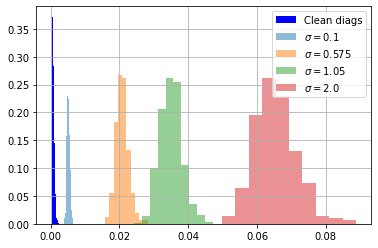

In [16]:
unb.plot_TU_circles(distrib_TU_clean, distrib_TU_noisy, sigmas)

As one can see, the larger the $\sigma$, the further the diagrams are from the barycenter one. Shift in the distribution can easily be detected this way!

# 2. Topological uncertainty on tensorflow neural network

For this section, you need `tensorflow 2` installed.

In [17]:
import tensorflow as tf

## 2.1 A First example

We briefly show how you can use TU on a simple tensorflow sequential network. We showcase this using the MNIST dataset.

In [18]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_train = x_train.reshape(len(x_train), 784)

x_test = x_test / 255.0
x_test = x_test.reshape(len(x_test), 784)

labels = np.unique(y_train)
nlabels = len(labels)

11501568/11490434 [==============================] - 0s 0us/step


We know build a tensorflow model with 2 hidden layers with 64 and 16 units, respectively.

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[x_train.shape[1]]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(nlabels, activation='softmax'),
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer='adam'
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 51,450
Trainable params: 51,450
Non-trainable params: 0
_________________________________________________________________


2022-02-16 12:51:17.483103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 12:51:17.483900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 12:51:17.484002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-16 12:51:17.484073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-16 12:51:17.484141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Now we compile and train the model. It should easily reach ~ 98% of (training) accuracy.

In [20]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

num_epochs = 10
model.fit(x_train, y_train, epochs=num_epochs)

Epoch 1/10


/home/felix/.cache/pypoetry/virtualenvs/topologicaluncertainty-FuTyNJF2-py3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 1s 584us/step - loss: 0.3121 - accuracy: 0.9103
Epoch 2/10
1875/1875 [==============================] - 1s 583us/step - loss: 0.1463 - accuracy: 0.9568
Epoch 3/10
1875/1875 [==============================] - 1s 583us/step - loss: 0.1084 - accuracy: 0.9674
Epoch 4/10
1875/1875 [==============================] - 1s 579us/step - loss: 0.0849 - accuracy: 0.9737
Epoch 5/10
1875/1875 [==============================] - 1s 579us/step - loss: 0.0702 - accuracy: 0.9785
Epoch 6/10
1875/1875 [==============================] - 1s 582us/step - loss: 0.0587 - accuracy: 0.9818
Epoch 7/10
1875/1875 [==============================] - 1s 583us/step - loss: 0.0509 - accuracy: 0.9840
Epoch 8/10
1875/1875 [==============================] - 1s 581us/step - loss: 0.0432 - accuracy: 0.9866
Epoch 9/10
1875/1875 [==============================] - 1s 580us/step - loss: 0.0370 - accuracy: 0.9880
Epoch 10/10
1875/1875 [==============================] - 1s 583us/step - lo

We briefly check that it did not grossly overfit (this experiment is just for illustrative purpose, we do not aim to have a fine-tuned network). In the following cell, `accuracy` should be about 97%.

In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 419us/step - loss: 0.1036 - accuracy: 0.9730


[0.10358133912086487, 0.9729999899864197]

Now, for **each class** and **only the final layer**, we will:
- Build the activation graphs for each training observation. Note: there are 6,000 observations per class in MNIST; using all of them may be overkill. In the following, we will only use 100 reference observations for each class, which turns out to be sufficient.
- Extract topological features (called _persistence diagrams_) from these activation graphs (which, in our specific setting, can be interpreted as extracting maximum spanning trees from the graphs). 
- Average these persistence diagrams to have a compact summary of how our training observations (for each class) activated the network. This average is encoded by a Fréchet mean, a.k.a. barycenter, of the corresponding diagrams.

Actually, all these three steps are handled by the function `bary_of_set_from_deep_model(model, x, layers_id)`, available from `utils.utils_tda` (imported as `utda` in this notebook). In this function, 
- `model` is our tensorflow model we have trained above.
- `x` is a set of points from which we compute diagrams and average them.
- `layers_id` is a subset of the model layers. Setting `layers_id=None` implies taking all layers into account. Here, as we have 3 layers, and we want to consider only the last one, we set `layers_id=[2]`.

In [22]:
n_obs_per_class = 100

# Take n_obs_per_class observation from each class in x_train:
xs = [x_train[np.where(y_train == ell)][:n_obs_per_class] for ell in labels]

# Now we get the corresponding barycenters.
layers_id = [2]
all_barycenters = [utda.barycenters_of_set_from_deep_model(model, x, layers_id=layers_id) for x in xs]

Now, given a new observation, we can get the class assigned by our `model` to it, and compute its distance to the barycenter of this class to check if something weird is happening. 

Let us take, for instance, the first 10 observations of the test set. The first one represents a 7.

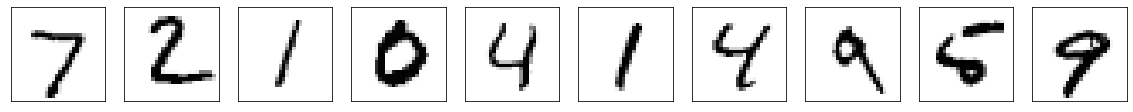

In [23]:
n_new_obs = 10
new_obs = x_test[:n_new_obs]
fig, axs = plt.subplots(1, n_new_obs, figsize=(20,3))
for i,ax in enumerate(axs):
    ax.imshow(new_obs[i].reshape(28,28), cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])

What does our model predict there?

In [24]:
predicted_classes = np.argmax(model.predict(new_obs), axis=-1)
confidences = np.max(model.predict(new_obs), axis=-1)
true_classes = y_test[:10]
for i in range(10):
    print("class predicted: %s (with confidence = %s%%) --- True label: %s" 
          %(predicted_classes[i], np.round(100*confidences[i], 1), true_classes[i]))
    print("***")

class predicted: 7 (with confidence = 100.0%) --- True label: 7
***
class predicted: 2 (with confidence = 100.0%) --- True label: 2
***
class predicted: 1 (with confidence = 99.9%) --- True label: 1
***
class predicted: 0 (with confidence = 100.0%) --- True label: 0
***
class predicted: 4 (with confidence = 100.0%) --- True label: 4
***
class predicted: 1 (with confidence = 100.0%) --- True label: 1
***
class predicted: 4 (with confidence = 100.0%) --- True label: 4
***
class predicted: 9 (with confidence = 96.1%) --- True label: 9
***
class predicted: 5 (with confidence = 100.0%) --- True label: 5
***
class predicted: 9 (with confidence = 99.9%) --- True label: 9
***


As we can see, our network is correct most of the time (unless one has been very unlucky with the random seed used for training) and is quite confident in its predictions.

Now, what's the _Topological uncertainty_ of these new observations? That is, what is the distance between the persistence diagrams (of the activation graphs) of these new observations and the barycenters of the corresponding class?

In [25]:
# First, we compute the diagram of this new observation
utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id)

array([0.10266438, 0.36765026, 0.20354491, 0.13033694, 0.12341493,
       0.10347086, 0.21919109, 0.14098542, 0.3263466 , 0.39579135])

To get an idea of what these values represent, let us look at how our model reacts to Out-of-distribution data coming from the `Fashion MNIST` dataset.

4431872/4422102 [==============================] - 0s 0us/step


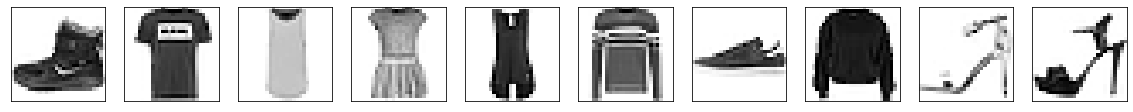

In [26]:
fmnist = tf.keras.datasets.fashion_mnist

(x_train_fmnist, y_train_fmnist) = fmnist.load_data()[0]
x_train_fmnist = x_train_fmnist / 255.0
x_train_fmnist = x_train_fmnist.reshape(len(x_train_fmnist), 784)

nplots = 10
fix, axs = plt.subplots(1, nplots, figsize=(20,3))

for i, ax in enumerate(axs):
    (ax.imshow(x_train_fmnist[i].reshape(28,28), cmap='Greys'), ax.set_xticks([]), ax.set_yticks([]))

In [27]:
ood_samples = x_train_fmnist[:10]
utda.topological_uncertainty(model, ood_samples, all_barycenters, layers_id=layers_id)

array([1.318554  , 1.66350721, 0.28908361, 0.90526274, 0.86300416,
       0.98912439, 0.58751247, 1.6411938 , 0.14217416, 0.4995568 ])

As one can see, these values are much higher (except perhaps for the 9th image). This way, topological uncertainty can be used as a way to detect out-of-distribution samples. One may wonder if this could be read in the confidence of the network directly...

In [28]:
ood_confidences = np.max(model.predict(ood_samples), axis=-1)
print(ood_confidences)

[1.         0.99915326 0.9999671  0.9932979  0.99990034 1.
 1.         1.         0.93637604 0.7482326 ]


For most predictions, the network remains extremely confident in its predictions (while, of course, the prediction itself does not make sense)! Thus, confidence cannot be used as a reliable way to detect Out-of-Distribution samples while TU can help there.

## 2.2 Paper experiment: OOD detection on graph dataset

In [29]:
import pandas as pd

Pick the dataset you want to work with (`'MUTAG'` or `'COX2'`) as your Training set (we suggest to start `'MUTAG'`). 

In [30]:
dataset = 'MUTAG'

In [31]:
if dataset == 'MUTAG':
    dataset_ood = 'COX2'
elif dataset == 'COX2':
    dataset_ood = 'MUTAG'

In [32]:
feat = pd.read_csv('./datasets/%s/%s.csv' %(dataset,dataset), index_col=0, header=0)
x_train, y_train = np.array(feat)[:,1:], np.array(feat['label'])

`feat` store the spectral features built on top of each graph. `evalN` correspond to the `N`-th eigenvalue of the normalized Laplacian of the graph (padded to 30 eigenvalues), while the following quantiles correspond to the Heat-Kernel-Signature (value) map evaluated with $t=10$.

The first column of `feat` corresponds to labels (taking value in `0`,`1` as this is a binary classification problem.

In [33]:
feat

,label,eval0,eval1,eval2,eval3,eval4,eval5,eval6,eval7,eval8,...,10.0-percent10,10.0-percent20,10.0-percent30,10.0-percent40,10.0-percent50,10.0-percent60,10.0-percent70,10.0-percent80,10.0-percent90,10.0-percent100
0,1,2.000000,1.935789,1.806565,1.692739,1.516169,1.500000,1.302172,1.283846,1.000000,...,0.073968,0.078373,0.083234,0.086899,0.093140,0.099276,0.104903,0.115026,0.123847,0.220578
1,0,2.000000,1.887105,1.769244,1.535183,1.422757,1.269871,1.000000,0.730129,0.577243,...,0.082667,0.090645,0.092821,0.096999,0.099753,0.112263,0.114826,0.120913,0.124706,0.210941
2,0,2.000000,1.887105,1.769244,1.535183,1.422757,1.269871,1.000000,0.730129,0.577243,...,0.082667,0.090645,0.092821,0.096999,0.099754,0.112264,0.114827,0.120913,0.124707,0.210943
3,1,1.968440,1.944924,1.879056,1.704426,1.594534,1.520651,1.409780,1.386936,1.150122,...,0.073967,0.079857,0.080076,0.086424,0.088624,0.091008,0.094584,0.105299,0.111327,0.207201
4,0,2.000000,1.856040,1.715183,1.427683,1.212175,1.000000,0.787825,0.572317,0.284817,...,0.066821,0.081685,0.081685,0.096868,0.107860,0.113531,0.141626,0.156696,0.178135,0.215393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,1,1.970788,1.964440,1.865129,1.831552,1.726228,1.553545,1.490822,1.422498,1.340695,...,0.077156,0.077959,0.079306,0.080343,0.080437,0.083673,0.088596,0.091853,0.115181,0.208884
184,0,2.000000,1.876146,1.847149,1.524804,1.394909,1.000000,1.000000,1.000000,0.605091,...,0.080408,0.080571,0.080817,0.087852,0.090901,0.108419,0.125597,0.154202,0.202140,0.211148
185,0,1.968590,1.821959,1.799248,1.512297,1.394731,1.000000,0.863041,0.713542,0.487643,...,0.083537,0.084318,0.087494,0.095526,0.108254,0.114312,0.128439,0.137119,0.138423,0.220978
186,1,2.000000,1.940580,1.896098,1.782380,1.574275,1.554004,1.515046,1.411485,1.290744,...,0.078088,0.081965,0.083402,0.088430,0.088590,0.090959,0.092160,0.110956,0.110977,0.220093


### Step 1: Training the model

We train the model using `tensorflow 2` on the `x_train` corresponding to `dataset`.

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax'),
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=1E-4)

model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=50, verbose=0)  # Turn verbose to 1 to have training details.

/home/felix/.cache/pypoetry/virtualenvs/topologicaluncertainty-FuTyNJF2-py3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


### Step 2 : Computing graphs on the training dataset and Fréchet means per class

In [35]:
nlayer = 2  # Our model has 2 layers that contains a weight matrix W (BatchNormalization layers can be considered as activation maps).
nlabel = 2  # This is a binary classification problem

We compute the activation graphs when `x_train` goes through `model` (that is now trained).

In [36]:
graphs = ug.build_graphs_from_deep_model(model, x_train)

We then extract persistence diagrams (Maximum Spanning Trees) from these weighted graphs.

In [37]:
diags = utda.diags_from_graphs(graphs)

Now, we compute the Fréchet means for each class (here, we have $K=2$ classes).

In [38]:
predicted_class_on_train = np.argmax(model.predict(x_train), axis=-1)
wbarys = [utda.barycenters_of_set_from_deep_model(model, x_train[np.where(predicted_class_on_train==c)]) 
          for c in range(nlabel)]

`wbarys[c][ell]` represents the average persistence diagram of the `ell`-th layer for points in `x_train` that are classified as `c` by the network.

### Step 3: Computing Distribution of TUs on the training distribution.

Now, we can compute the Topological Uncertainty for each point in `x_train`, giving a distribution of training Topological Uncertainties.

In [39]:
dists_true = [np.mean([utda.wasserstein_distance_1D(d[ell], wbarys[c][ell], average=True) 
                       for ell in range(nlayer)])
             for c,d in zip(predicted_class_on_train, diags)]

### Step 4: Computing distribution of TUs of Fake/OOD datasets (against the training Fréchet means)

We compute the TU for points in OOD sets, based on the Fréchet means we have stored in `wbarys`.

In [40]:
feat_fake = pd.read_csv('./datasets/Fake-%s/Fake-%s.csv' %(dataset,dataset), index_col=0, header=0)
x_fake, y_fake = np.array(feat_fake)[:,1:], np.array(feat_fake['label'])  
# Note: y_fake shouldn't be used, it's meaningless.

In [41]:
graphs_fake = ug.build_graphs_from_deep_model(model, x_fake)
diags_fake = utda.diags_from_graphs(graphs_fake)

predicted_class_fake = np.argmax(model.predict(x_fake), axis=-1)

dists_fake = [np.mean([utda.wasserstein_distance_1D(d[ell], wbarys[c][ell], average=True) 
                       for ell in range(nlayer)])
             for c,d in zip(predicted_class_fake, diags_fake)]

In [42]:
feat_ood = pd.read_csv('./datasets/%s/%s.csv' %(dataset_ood,dataset_ood), index_col=0, header=0)
x_ood, y_ood = np.array(feat_ood)[:,1:], np.array(feat_ood['label'])

In [43]:
graphs_ood = ug.build_graphs_from_deep_model(model, x_ood)
diags_ood = utda.diags_from_graphs(graphs_ood)
predicted_class_ood = np.argmax(model.predict(x_ood), axis=-1)
dists_ood = [np.mean([utda.wasserstein_distance_1D(d[ell], wbarys[c][ell]) 
                       for ell in range(nlayer)])
             for c,d in zip(predicted_class_ood, diags_ood)]

In [44]:
distribs_TUs = [dists_true, dists_fake, dists_ood]

### Step 5: Computing network confidences for each dataset.

Now, we compute the distributions of network *confidence*. Note that the final activation of the network is a `softmax`, so we simply have to take its maximum entry.

In [45]:
confidences_true = np.max(model.predict(x_train), axis=-1)
confidences_fake = np.max(model.predict(x_fake), axis=-1)
confidences_ood = np.max(model.predict(x_ood), axis=-1)

confidences = [confidences_true, confidences_fake, confidences_ood]

### Step 6: Visualization

We visualize these distributions.

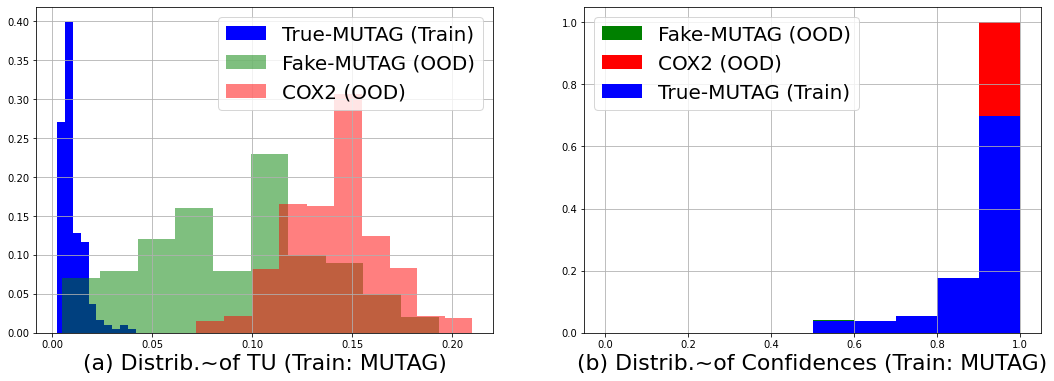

In [46]:
unb.plot_TU_and_confidence(distribs_TUs, confidences, dataset=dataset, dataset_ood=dataset_ood)

**Interpretation:** 

*(left)* The distribution of topological uncertainties of training data is concentrated on low values. In comparison, the topological uncertainties of OOD data are significantly higher, allowing for their detection by applying a threshold. 

*(right)* Perhaps surprisingly, in most (all?) runs, the network tends to be *over-confident* on OOD data (values very close to $1$), while it can be slightly less confident on training data. As a consequence, the baseline detector which labels low-confidence input as OOD-data would perform poorly in this setting.

------

# (Optional) Rebuild the Fake datasets and all the graph features

For the sake of simplicity, we provided preprocessed graphs as `.csv` files. If you want to rebuild Fake-datasets from scratch and all the corresponding graph features, do the following:
1. Delete the *content* of `./Fake-MUTAG/mat/` and `./Fake-COX2/mat/` (but do not delete the folders, the script do not create them automatically).
2. Delete all the `.csv` (from the 4 folders) files . 
3. Install the Additional dependencies (see below).
4. Run the following cells.

Note that the Fake-datasets are made of 100 random graphs. Therefore, the plot you end up with might slightly differ, although the global intuition (TU of training data is concentrated on low values, the TU of ood data tends to be larger) remains consistently true over runs. 

Additional dependencies:

- `networkx 2.5` (used to generate random graphs for fake datasets)
- `scipy 1.5.2` (used to compute the graphs features)


In [47]:
import utils.utils_data as udata

ModuleNotFoundError: No module named 'scipy'

### Generate the Fake datasets

We start by generating the Fake datasets as described in the paper.

In [48]:
for dataset in ['MUTAG', 'COX2']:
    udata.generate_fake_graphs(dataset)

NameError: name 'udata' is not defined

### Turn graphs into finite-dimensional features

In [ ]:
for dataset in ['MUTAG', 'COX2']:
    udata.build_csv(dataset)
    udata.build_csv('Fake-' + dataset)